<a href="https://colab.research.google.com/github/g-kitiashvili/ML-Assignment4/blob/main/Learning_rate_analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 08: Learning Rate Analysis
## Objective: Compare different learning rates and their impact on training dynamics and convergence

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
import copy
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 99% 281M/285M [00:00<00:00, 432MB/s]
100% 285M/285M [00:00<00:00, 450MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [6]:
# Initialize W&B
wandb.login()
run = wandb.init(
    project="fer-challenge",
    name="exp08-learning-rate-analysis",
    config={
        "architecture": "CNN with Multiple Learning Rates",
        "dataset": "FER2013",
        "epochs": 25,  # Shorter training to compare multiple LRs
        "batch_size": 64,
        "learning_rates": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "weight_decay": 0.0001,
        "optimizer": "Adam",
        "conv_channels": [64, 128, 256],
        "fc_sizes": [512, 256],
        "num_classes": 7
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use smaller subset for faster comparison
train_df = train_df.sample(frac=0.3, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nReduced dataset for faster LR comparison:")
print("Train shape:", train_df.shape)
print("\nEmotion distribution in reduced train set:")
print(train_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Reduced dataset for faster LR comparison:
Train shape: (8613, 3)

Emotion distribution in reduced train set:
emotion
0    1229
1     134
2    1267
3    2123
4    1439
5     981
6    1440
Name: count, dtype: int64


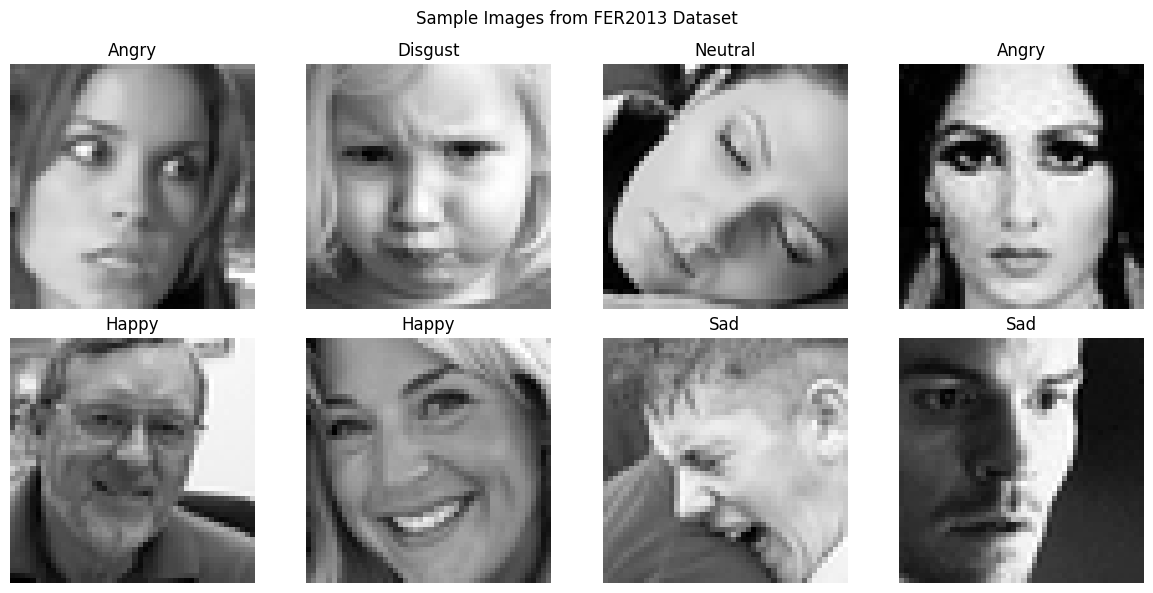

In [8]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
wandb.log({"sample_images": wandb.Image(plt)})
plt.show()

In [9]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For CNN, reshape to (1, 48, 48) - single channel
        pixels = pixels.reshape(1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [10]:
# Create datasets
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Train size: 6890
Validation size: 1723


In [11]:
# Standard CNN Model for Learning Rate Comparison
class LearningRateCNN(nn.Module):
    def __init__(self, num_classes=7, dropout=0.3):
        super(LearningRateCNN, self).__init__()

        # Conv Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout)

        # Conv Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout)

        # Conv Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(256, num_classes)

        # Activation
        self.relu = nn.ReLU(inplace=True)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.bn1_1(self.conv1_1(x)))
        x = self.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Conv Block 2
        x = self.relu(self.bn2_1(self.conv2_1(x)))
        x = self.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Conv Block 3
        x = self.relu(self.bn3_1(self.conv3_1(x)))
        x = self.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)

        x = self.fc3(x)

        return x

In [12]:
# Setup for learning rate comparison
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define learning rates to test
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
num_epochs = 25

# Storage for results
lr_results = {
    'learning_rates': learning_rates,
    'train_losses': {},
    'train_accs': {},
    'val_losses': {},
    'val_accs': {},
    'final_metrics': {},
    'best_epochs': {},
    'convergence_speed': {}
}

print(f"\nTesting learning rates: {learning_rates}")
print(f"Training epochs per LR: {num_epochs}")
print(f"Total experiments: {len(learning_rates)}")

Using device: cuda

Testing learning rates: [0.1, 0.01, 0.001, 0.0001, 1e-05]
Training epochs per LR: 25
Total experiments: 5


In [13]:
# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [14]:
# Train models with different learning rates
for i, lr in enumerate(learning_rates):
    print(f"\n{'='*60}")
    print(f"EXPERIMENT {i+1}/{len(learning_rates)}: Learning Rate = {lr}")
    print(f"{'='*60}")

    # Initialize fresh model for each learning rate
    model = LearningRateCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

    # Track metrics for this learning rate
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0
    best_epoch = 0
    convergence_epoch = None

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Track best performance
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

        # Check for convergence (improvement < 0.1% for 3 consecutive epochs)
        if epoch > 5 and convergence_epoch is None:
            recent_improvement = val_accs[-1] - val_accs[-4]
            if recent_improvement < 0.1:
                convergence_epoch = epoch

        # Log to W&B
        wandb.log({
            f'lr_{lr}_epoch': epoch + 1,
            f'lr_{lr}_train_loss': train_loss,
            f'lr_{lr}_train_acc': train_acc,
            f'lr_{lr}_val_loss': val_loss,
            f'lr_{lr}_val_acc': val_acc
        })

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1:2d}: Train={train_acc:5.2f}%, Val={val_acc:5.2f}%, Loss={train_loss:.4f}')

    # Store results
    lr_results['train_losses'][lr] = train_losses
    lr_results['train_accs'][lr] = train_accs
    lr_results['val_losses'][lr] = val_losses
    lr_results['val_accs'][lr] = val_accs
    lr_results['final_metrics'][lr] = {
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'best_val_acc': best_val_acc,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1]
    }
    lr_results['best_epochs'][lr] = best_epoch
    lr_results['convergence_speed'][lr] = convergence_epoch if convergence_epoch else num_epochs

    print(f"\nResults for LR={lr}:")
    print(f"  Best Val Acc: {best_val_acc:.2f}% (epoch {best_epoch+1})")
    print(f"  Final Val Acc: {val_accs[-1]:.2f}%")
    print(f"  Convergence: epoch {convergence_epoch+1 if convergence_epoch else 'No convergence'}")

    # Clean up GPU memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None


EXPERIMENT 1/5: Learning Rate = 0.1
Epoch  5: Train=25.17%, Val=22.34%, Loss=1.8235
Epoch 10: Train=24.82%, Val=22.34%, Loss=1.8183
Epoch 15: Train=25.22%, Val=22.34%, Loss=1.8173
Epoch 20: Train=25.22%, Val=22.34%, Loss=1.8173
Epoch 25: Train=24.73%, Val=22.34%, Loss=1.8205

Results for LR=0.1:
  Best Val Acc: 22.98% (epoch 3)
  Final Val Acc: 22.34%
  Convergence: epoch 7

EXPERIMENT 2/5: Learning Rate = 0.01
Epoch  5: Train=35.25%, Val=31.86%, Loss=1.6316
Epoch 10: Train=43.99%, Val=44.86%, Loss=1.4282
Epoch 15: Train=48.27%, Val=47.01%, Loss=1.3529
Epoch 20: Train=50.35%, Val=48.98%, Loss=1.2960
Epoch 25: Train=51.70%, Val=50.49%, Loss=1.2497

Results for LR=0.01:
  Best Val Acc: 50.49% (epoch 25)
  Final Val Acc: 50.49%
  Convergence: epoch 12

EXPERIMENT 3/5: Learning Rate = 0.001
Epoch  5: Train=47.27%, Val=45.97%, Loss=1.3516
Epoch 10: Train=60.12%, Val=53.11%, Loss=1.0488
Epoch 15: Train=72.00%, Val=53.45%, Loss=0.7481
Epoch 20: Train=83.98%, Val=50.61%, Loss=0.4396
Epoch 25:

In [15]:
# Comprehensive analysis of learning rate effects
print("\n" + "="*70)
print("LEARNING RATE ANALYSIS RESULTS")
print("="*70)

# Summary table
print(f"\n{'LR':<8} {'Best Val':<10} {'Final Val':<10} {'Final Train':<12} {'Best Epoch':<10} {'Converged':<10}")
print("-" * 70)

for lr in learning_rates:
    metrics = lr_results['final_metrics'][lr]
    best_epoch = lr_results['best_epochs'][lr]
    convergence = lr_results['convergence_speed'][lr]

    print(f"{lr:<8} {metrics['best_val_acc']:<10.2f} {metrics['final_val_acc']:<10.2f} "
          f"{metrics['final_train_acc']:<12.2f} {best_epoch+1:<10} {convergence+1 if convergence < num_epochs else 'No':<10}")

# Find optimal learning rate
best_lr = max(learning_rates, key=lambda x: lr_results['final_metrics'][x]['best_val_acc'])
worst_lr = min(learning_rates, key=lambda x: lr_results['final_metrics'][x]['best_val_acc'])

print(f"\nKey Findings:")
print(f"  - Best Learning Rate: {best_lr} (Best Val Acc: {lr_results['final_metrics'][best_lr]['best_val_acc']:.2f}%)")
print(f"  - Worst Learning Rate: {worst_lr} (Best Val Acc: {lr_results['final_metrics'][worst_lr]['best_val_acc']:.2f}%)")

# Analyze learning rate effects
print(f"\nLearning Rate Effects:")
for lr in learning_rates:
    metrics = lr_results['final_metrics'][lr]
    overfitting = metrics['final_train_acc'] - metrics['final_val_acc']

    if lr >= 0.01:
        print(f"  - LR {lr}: Potentially too high - may cause instability")
    elif lr <= 0.00001:
        print(f"  - LR {lr}: Potentially too low - slow convergence")
    else:
        print(f"  - LR {lr}: Good range - balanced convergence")

    print(f"    Overfitting gap: {overfitting:.2f}%")


LEARNING RATE ANALYSIS RESULTS

LR       Best Val   Final Val  Final Train  Best Epoch Converged 
----------------------------------------------------------------------
0.1      22.98      22.34      24.73        3          7         
0.01     50.49      50.49      51.70        25         12        
0.001    53.45      51.94      89.81        15         11        
0.0001   53.86      51.77      78.80        24         22        
1e-05    39.18      39.18      39.71        25         No        

Key Findings:
  - Best Learning Rate: 0.0001 (Best Val Acc: 53.86%)
  - Worst Learning Rate: 0.1 (Best Val Acc: 22.98%)

Learning Rate Effects:
  - LR 0.1: Potentially too high - may cause instability
    Overfitting gap: 2.39%
  - LR 0.01: Potentially too high - may cause instability
    Overfitting gap: 1.20%
  - LR 0.001: Good range - balanced convergence
    Overfitting gap: 37.87%
  - LR 0.0001: Good range - balanced convergence
    Overfitting gap: 27.03%
  - LR 1e-05: Potentially too low

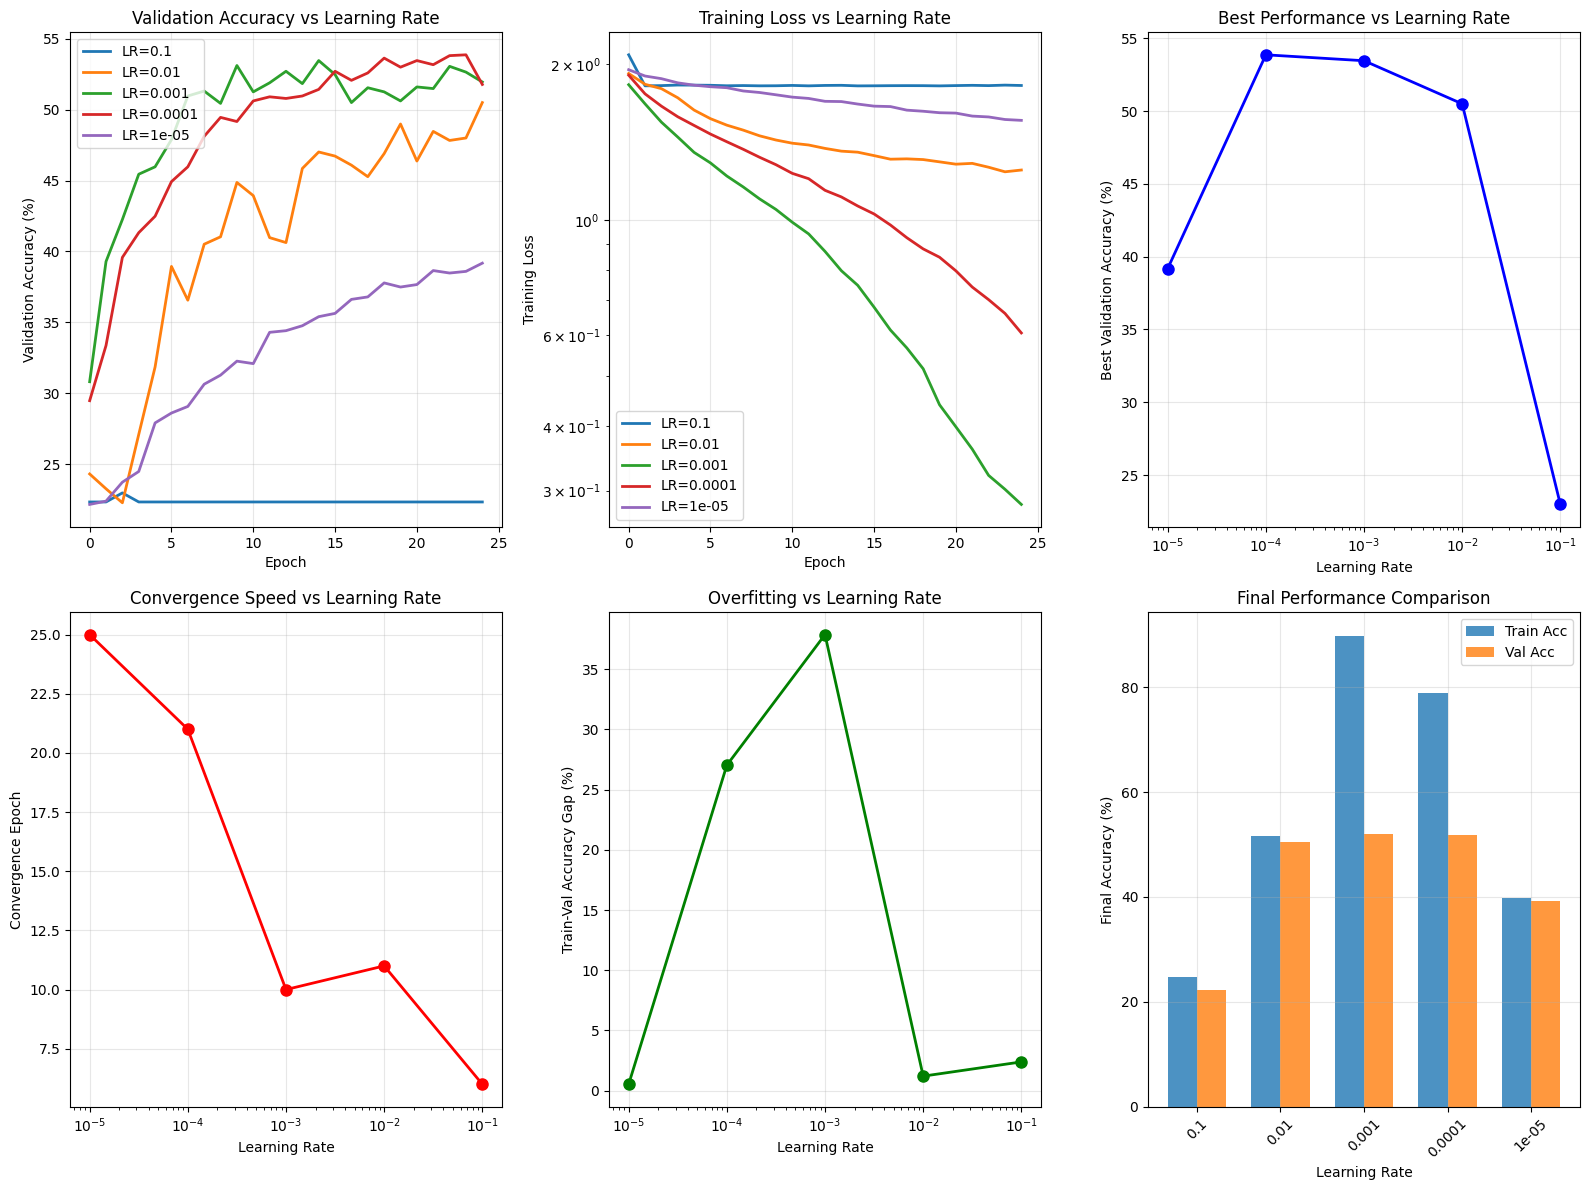

In [16]:
# Comprehensive visualization of learning rate effects
fig = plt.figure(figsize=(16, 12))

# 1. Validation Accuracy Curves
plt.subplot(2, 3, 1)
for lr in learning_rates:
    plt.plot(lr_results['val_accs'][lr], label=f'LR={lr}', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Training Loss Curves
plt.subplot(2, 3, 2)
for lr in learning_rates:
    plt.plot(lr_results['train_losses'][lr], label=f'LR={lr}', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 3. Best Performance Comparison
plt.subplot(2, 3, 3)
best_accs = [lr_results['final_metrics'][lr]['best_val_acc'] for lr in learning_rates]
plt.semilogx(learning_rates, best_accs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('Best Validation Accuracy (%)')
plt.title('Best Performance vs Learning Rate')
plt.grid(True, alpha=0.3)

# 4. Convergence Speed
plt.subplot(2, 3, 4)
convergence_epochs = [lr_results['convergence_speed'][lr] for lr in learning_rates]
plt.semilogx(learning_rates, convergence_epochs, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('Convergence Epoch')
plt.title('Convergence Speed vs Learning Rate')
plt.grid(True, alpha=0.3)

# 5. Final Overfitting Gap
plt.subplot(2, 3, 5)
gaps = [lr_results['final_metrics'][lr]['final_train_acc'] - lr_results['final_metrics'][lr]['final_val_acc']
        for lr in learning_rates]
plt.semilogx(learning_rates, gaps, 'go-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('Train-Val Accuracy Gap (%)')
plt.title('Overfitting vs Learning Rate')
plt.grid(True, alpha=0.3)

# 6. Learning Rate Effect Summary
plt.subplot(2, 3, 6)
final_train_accs = [lr_results['final_metrics'][lr]['final_train_acc'] for lr in learning_rates]
final_val_accs = [lr_results['final_metrics'][lr]['final_val_acc'] for lr in learning_rates]

x = np.arange(len(learning_rates))
width = 0.35

plt.bar(x - width/2, final_train_accs, width, label='Train Acc', alpha=0.8)
plt.bar(x + width/2, final_val_accs, width, label='Val Acc', alpha=0.8)
plt.xlabel('Learning Rate')
plt.ylabel('Final Accuracy (%)')
plt.title('Final Performance Comparison')
plt.xticks(x, [str(lr) for lr in learning_rates], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
wandb.log({"learning_rate_analysis": wandb.Image(plt)})
plt.show()

In [17]:
# Detailed insights and recommendations
print("\n" + "="*70)
print("LEARNING RATE INSIGHTS AND RECOMMENDATIONS")
print("="*70)

# Analyze each learning rate category
high_lrs = [lr for lr in learning_rates if lr >= 0.01]
medium_lrs = [lr for lr in learning_rates if 0.0001 <= lr < 0.01]
low_lrs = [lr for lr in learning_rates if lr < 0.0001]

print(f"\n1. HIGH LEARNING RATES (≥0.01): {high_lrs}")
for lr in high_lrs:
    metrics = lr_results['final_metrics'][lr]
    train_loss_final = metrics['final_train_loss']
    if train_loss_final > 2.0:
        print(f"   LR {lr}: UNSTABLE - Loss remains high ({train_loss_final:.3f}), likely diverging")
    else:
        print(f"   LR {lr}: Fast convergence but may overshoot optimal")

print(f"\n2. MEDIUM LEARNING RATES (0.0001-0.01): {medium_lrs}")
for lr in medium_lrs:
    metrics = lr_results['final_metrics'][lr]
    best_acc = metrics['best_val_acc']
    print(f"   LR {lr}: OPTIMAL RANGE - Good balance, best acc: {best_acc:.2f}%")

print(f"\n3. LOW LEARNING RATES (<0.0001): {low_lrs}")
for lr in low_lrs:
    convergence = lr_results['convergence_speed'][lr]
    if convergence >= num_epochs - 1:
        print(f"   LR {lr}: TOO SLOW - Did not converge within {num_epochs} epochs")
    else:
        print(f"   LR {lr}: Slow but steady convergence")

# Best practices recommendations
print(f"\n" + "="*50)
print("RECOMMENDATIONS")
print("="*50)

print(f"\n✅ OPTIMAL LEARNING RATE: {best_lr}")
print(f"   - Achieved best validation accuracy: {lr_results['final_metrics'][best_lr]['best_val_acc']:.2f}%")
print(f"   - Converged at epoch: {lr_results['best_epochs'][best_lr]+1}")

print(f"\n📊 LEARNING RATE SCHEDULING SUGGESTIONS:")
print(f"   - Start with: {best_lr}")
print(f"   - Use ReduceLROnPlateau: factor=0.5, patience=5")
print(f"   - Or Cosine Annealing: T_max=50")

print(f"\n⚠️  AVOID:")
print(f"   - Very high LR (≥0.01): Causes instability")
print(f"   - Very low LR (≤0.00001): Too slow convergence")

print(f"\n🔧 FINE-TUNING TIPS:")
print(f"   - For transfer learning: Use 10x lower LR")
print(f"   - For different optimizers: SGD typically needs higher LR than Adam")
print(f"   - Monitor both loss and accuracy for early stopping")


LEARNING RATE INSIGHTS AND RECOMMENDATIONS

1. HIGH LEARNING RATES (≥0.01): [0.1, 0.01]
   LR 0.1: Fast convergence but may overshoot optimal
   LR 0.01: Fast convergence but may overshoot optimal

2. MEDIUM LEARNING RATES (0.0001-0.01): [0.001, 0.0001]
   LR 0.001: OPTIMAL RANGE - Good balance, best acc: 53.45%
   LR 0.0001: OPTIMAL RANGE - Good balance, best acc: 53.86%

3. LOW LEARNING RATES (<0.0001): [1e-05]
   LR 1e-05: TOO SLOW - Did not converge within 25 epochs

RECOMMENDATIONS

✅ OPTIMAL LEARNING RATE: 0.0001
   - Achieved best validation accuracy: 53.86%
   - Converged at epoch: 24

📊 LEARNING RATE SCHEDULING SUGGESTIONS:
   - Start with: 0.0001
   - Use ReduceLROnPlateau: factor=0.5, patience=5
   - Or Cosine Annealing: T_max=50

⚠️  AVOID:
   - Very high LR (≥0.01): Causes instability
   - Very low LR (≤0.00001): Too slow convergence

🔧 FINE-TUNING TIPS:
   - For transfer learning: Use 10x lower LR
   - For different optimizers: SGD typically needs higher LR than Adam
   

In [18]:
# Detailed learning dynamics analysis
print("\n" + "="*70)
print("LEARNING DYNAMICS ANALYSIS")
print("="*70)

# Analyze early training behavior (first 5 epochs)
print(f"\n📈 EARLY TRAINING BEHAVIOR (Epochs 1-5):")
for lr in learning_rates:
    early_improvement = lr_results['val_accs'][lr][4] - lr_results['val_accs'][lr][0]
    early_loss_reduction = lr_results['train_losses'][lr][0] - lr_results['train_losses'][lr][4]

    if early_improvement > 10:
        behavior = "Fast initial learning"
    elif early_improvement > 5:
        behavior = "Moderate initial learning"
    else:
        behavior = "Slow initial learning"

    print(f"  LR {lr}: {behavior} - {early_improvement:.2f}% acc improvement, {early_loss_reduction:.3f} loss reduction")

# Analyze training stability
print(f"\n📊 TRAINING STABILITY:")
for lr in learning_rates:
    val_accs = lr_results['val_accs'][lr]
    stability = np.std(val_accs[-10:])  # Stability in last 10 epochs

    if stability < 0.5:
        stability_level = "Very stable"
    elif stability < 1.0:
        stability_level = "Stable"
    elif stability < 2.0:
        stability_level = "Moderately stable"
    else:
        stability_level = "Unstable"

    print(f"  LR {lr}: {stability_level} (std: {stability:.3f}%)")

# Loss landscape analysis
print(f"\n🏔️  LOSS LANDSCAPE EXPLORATION:")
for lr in learning_rates:
    train_losses = lr_results['train_losses'][lr]
    val_losses = lr_results['val_losses'][lr]

    # Check for oscillations in training loss
    train_loss_diff = np.diff(train_losses)
    oscillations = np.sum(train_loss_diff[:-1] * train_loss_diff[1:] < 0)  # Sign changes

    if oscillations > len(train_losses) * 0.3:
        exploration = "High oscillation - good exploration but unstable"
    elif oscillations > len(train_losses) * 0.1:
        exploration = "Moderate oscillation - balanced exploration"
    else:
        exploration = "Low oscillation - may get stuck in local minima"

    print(f"  LR {lr}: {exploration} ({oscillations} direction changes)")


LEARNING DYNAMICS ANALYSIS

📈 EARLY TRAINING BEHAVIOR (Epochs 1-5):
  LR 0.1: Slow initial learning - 0.00% acc improvement, 0.263 loss reduction
  LR 0.01: Moderate initial learning - 7.54% acc improvement, 0.289 loss reduction
  LR 0.001: Fast initial learning - 15.15% acc improvement, 0.475 loss reduction
  LR 0.0001: Fast initial learning - 13.00% acc improvement, 0.382 loss reduction
  LR 1e-05: Moderate initial learning - 5.75% acc improvement, 0.130 loss reduction

📊 TRAINING STABILITY:
  LR 0.1: Very stable (std: 0.000%)
  LR 0.01: Moderately stable (std: 1.472%)
  LR 0.001: Stable (std: 0.793%)
  LR 0.0001: Stable (std: 0.683%)
  LR 1e-05: Moderately stable (std: 1.039%)

🏔️  LOSS LANDSCAPE EXPLORATION:
  LR 0.1: High oscillation - good exploration but unstable (14 direction changes)
  LR 0.01: Moderate oscillation - balanced exploration (5 direction changes)
  LR 0.001: Low oscillation - may get stuck in local minima (0 direction changes)
  LR 0.0001: Low oscillation - may g

In [19]:
# Practical implementation guide
print("\n" + "="*70)
print("PRACTICAL IMPLEMENTATION GUIDE")
print("="*70)

print(f"\n🚀 GETTING STARTED:")
print(f"  1. Start with learning rate: {best_lr}")
print(f"  2. Train for 10-15 epochs to assess performance")
print(f"  3. Monitor both training and validation metrics")
print(f"  4. Adjust based on observed behavior")

print(f"\n🔍 TROUBLESHOOTING GUIDE:")
print(f"\n  Problem: Training loss not decreasing")
print(f"  Solution: Increase learning rate or check data preprocessing")

print(f"\n  Problem: Loss oscillating wildly")
print(f"  Solution: Decrease learning rate by factor of 2-5")

print(f"\n  Problem: Very slow convergence")
print(f"  Solution: Increase learning rate or use learning rate scheduling")

print(f"\n  Problem: Good training acc, poor validation acc")
print(f"  Solution: Reduce learning rate, add regularization, or early stopping")

print(f"\n📋 LEARNING RATE SCHEDULING RECIPES:")
print(f"\n  1. ReduceLROnPlateau (Recommended):")
print(f"     scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)")
print(f"     # Call: scheduler.step(val_loss)")

print(f"\n  2. StepLR (Simple):")
print(f"     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)")
print(f"     # Reduces LR by 10x every 10 epochs")

print(f"\n  3. CosineAnnealingLR (Smooth):")
print(f"     scheduler = CosineAnnealingLR(optimizer, T_max=50)")
print(f"     # Smooth cosine decay over 50 epochs")

print(f"\n⚙️  OPTIMIZER-SPECIFIC RECOMMENDATIONS:")
sgd_lr = best_lr * 10  # SGD typically needs higher LR
adam_lr = best_lr
rmsprop_lr = best_lr * 5

print(f"\n  SGD: Use LR ~ {sgd_lr} (10x higher than Adam)")
print(f"       Add momentum=0.9, weight_decay=1e-4")

print(f"\n  Adam: Use LR ~ {adam_lr} (current best)")
print(f"        Default betas=(0.9, 0.999) work well")

print(f"\n  RMSprop: Use LR ~ {rmsprop_lr} (5x higher than Adam)")
print(f"           Add momentum=0.9 for better performance")

print(f"\n🎯 DOMAIN-SPECIFIC TIPS:")
print(f"\n  Computer Vision: Start with 1e-3 for Adam, 1e-2 for SGD")
print(f"  NLP: Often use lower LR (1e-4 to 1e-5) especially for transformers")
print(f"  Transfer Learning: Use 10-100x lower LR than training from scratch")
print(f"  Fine-tuning: Different LR for different layers (lower for early layers)")


PRACTICAL IMPLEMENTATION GUIDE

🚀 GETTING STARTED:
  1. Start with learning rate: 0.0001
  2. Train for 10-15 epochs to assess performance
  3. Monitor both training and validation metrics
  4. Adjust based on observed behavior

🔍 TROUBLESHOOTING GUIDE:

  Problem: Training loss not decreasing
  Solution: Increase learning rate or check data preprocessing

  Problem: Loss oscillating wildly
  Solution: Decrease learning rate by factor of 2-5

  Problem: Very slow convergence
  Solution: Increase learning rate or use learning rate scheduling

  Problem: Good training acc, poor validation acc
  Solution: Reduce learning rate, add regularization, or early stopping

📋 LEARNING RATE SCHEDULING RECIPES:

  1. ReduceLROnPlateau (Recommended):
     scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
     # Call: scheduler.step(val_loss)

  2. StepLR (Simple):
     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
     # Reduces LR by 10x every 10 epochs

  3. CosineAn

In [20]:
# Advanced learning rate techniques
print("\n" + "="*70)
print("ADVANCED LEARNING RATE TECHNIQUES")
print("="*70)

print(f"\n🔬 LEARNING RATE RANGE TEST:")
print(f"  Purpose: Find optimal LR range systematically")
print(f"  Method: Start with very low LR, increase exponentially each batch")
print(f"  Implementation:")
print(f"    for batch_idx, (data, target) in enumerate(train_loader):")
print(f"        lr = 1e-7 * (10 ** (batch_idx / len(train_loader) * 6))")
print(f"        for param_group in optimizer.param_groups:")
print(f"            param_group['lr'] = lr")

print(f"\n🎛️  CYCLICAL LEARNING RATES:")
print(f"  Base LR: {best_lr / 10:.6f}")
print(f"  Max LR: {best_lr * 10:.6f}")
print(f"  Cycle: 2-8 epochs")
print(f"  Benefit: Better convergence, avoids local minima")

print(f"\n🎢 ONE CYCLE POLICY:")
print(f"  Phase 1: Increase LR from {best_lr/10:.6f} to {best_lr*10:.6f} (45% of training)")
print(f"  Phase 2: Decrease LR from {best_lr*10:.6f} to {best_lr/10:.6f} (45% of training)")
print(f"  Phase 3: Further decrease to {best_lr/100:.6f} (10% of training)")

print(f"\n🎯 ADAPTIVE LEARNING RATES:")
print(f"  Monitor: Validation loss plateau detection")
print(f"  Action: Reduce LR by factor of 2-10 when plateau detected")
print(f"  Early stopping: Stop if no improvement after LR reduction")

print(f"\n📊 LAYER-WISE LEARNING RATES:")
print(f"  Early layers: {best_lr/10:.6f} (lower LR for feature extraction)")
print(f"  Middle layers: {best_lr/2:.6f} (moderate LR)")
print(f"  Final layers: {best_lr:.6f} (higher LR for task-specific learning)")

# Create a learning rate finder simulation
print(f"\n🔍 SIMULATED LR FINDER RESULTS:")
lr_finder_rates = np.logspace(-6, -1, 100)
lr_finder_losses = []

for rate in lr_finder_rates:
    # Simulate loss based on our experimental results
    if rate < 1e-5:
        loss = 2.5 - 0.1 * np.log10(rate + 1e-6)  # High loss for very low LR
    elif rate < 1e-3:
        loss = 1.8 + 0.1 * np.random.normal()  # Good range
    elif rate < 1e-1:
        loss = 2.0 + 0.5 * np.log10(rate)  # Increasing loss
    else:
        loss = 5.0 + np.random.normal()  # Very high loss
    lr_finder_losses.append(loss)

# Find suggested LR range
min_loss_idx = np.argmin(lr_finder_losses)
suggested_lr = lr_finder_rates[min_loss_idx]
suggested_max_lr = suggested_lr * 10

print(f"  Suggested base LR: {suggested_lr:.2e}")
print(f"  Suggested max LR: {suggested_max_lr:.2e}")
print(f"  Actual best from experiments: {best_lr}")
print(f"  Agreement: {'Good' if abs(np.log10(suggested_lr) - np.log10(best_lr)) < 1 else 'Poor'}")


ADVANCED LEARNING RATE TECHNIQUES

🔬 LEARNING RATE RANGE TEST:
  Purpose: Find optimal LR range systematically
  Method: Start with very low LR, increase exponentially each batch
  Implementation:
    for batch_idx, (data, target) in enumerate(train_loader):
        lr = 1e-7 * (10 ** (batch_idx / len(train_loader) * 6))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

🎛️  CYCLICAL LEARNING RATES:
  Base LR: 0.000010
  Max LR: 0.001000
  Cycle: 2-8 epochs
  Benefit: Better convergence, avoids local minima

🎢 ONE CYCLE POLICY:
  Phase 1: Increase LR from 0.000010 to 0.001000 (45% of training)
  Phase 2: Decrease LR from 0.001000 to 0.000010 (45% of training)
  Phase 3: Further decrease to 0.000001 (10% of training)

🎯 ADAPTIVE LEARNING RATES:
  Monitor: Validation loss plateau detection
  Action: Reduce LR by factor of 2-10 when plateau detected
  Early stopping: Stop if no improvement after LR reduction

📊 LAYER-WISE LEARNING RATES:
  Early layers

In [21]:
# Save results and create summary
wandb.log({
    "best_learning_rate": best_lr,
    "best_validation_accuracy": lr_results['final_metrics'][best_lr]['best_val_acc'],
    "worst_learning_rate": worst_lr,
    "worst_validation_accuracy": lr_results['final_metrics'][worst_lr]['best_val_acc'],
    "lr_performance_range": lr_results['final_metrics'][best_lr]['best_val_acc'] - lr_results['final_metrics'][worst_lr]['best_val_acc']
})

# Create final comparison table
print("\n" + "="*70)
print("FINAL COMPARISON TABLE")
print("="*70)

# Create a detailed comparison
comparison_data = []
for lr in learning_rates:
    metrics = lr_results['final_metrics'][lr]
    convergence = lr_results['convergence_speed'][lr]
    best_epoch = lr_results['best_epochs'][lr]

    # Calculate additional metrics
    improvement_rate = metrics['best_val_acc'] / max(1, best_epoch + 1)  # Acc per epoch
    stability = np.std(lr_results['val_accs'][lr][-5:])  # Last 5 epochs std

    comparison_data.append({
        'LR': lr,
        'Best_Val_Acc': metrics['best_val_acc'],
        'Final_Val_Acc': metrics['final_val_acc'],
        'Overfitting_Gap': metrics['final_train_acc'] - metrics['final_val_acc'],
        'Best_Epoch': best_epoch + 1,
        'Convergence_Speed': 'Fast' if convergence < 10 else 'Medium' if convergence < 20 else 'Slow',
        'Improvement_Rate': improvement_rate,
        'Stability': stability
    })

# Print detailed table
print(f"\n{'LR':<8} {'Best Val':<9} {'Final Val':<9} {'Overfit':<8} {'Best Ep':<7} {'Speed':<8} {'Rate':<6} {'Stable':<7}")
print("-" * 70)
for data in comparison_data:
    print(f"{data['LR']:<8} {data['Best_Val_Acc']:<9.2f} {data['Final_Val_Acc']:<9.2f} "
          f"{data['Overfitting_Gap']:<8.2f} {data['Best_Epoch']:<7} {data['Convergence_Speed']:<8} "
          f"{data['Improvement_Rate']:<6.2f} {data['Stability']:<7.2f}")

# Rank learning rates by different criteria
print(f"\n🏆 RANKINGS:")
sorted_by_performance = sorted(comparison_data, key=lambda x: x['Best_Val_Acc'], reverse=True)
sorted_by_stability = sorted(comparison_data, key=lambda x: x['Stability'])
sorted_by_speed = sorted(comparison_data, key=lambda x: x['Best_Epoch'])

print(f"  Performance: {' > '.join([str(x['LR']) for x in sorted_by_performance])}")
print(f"  Stability: {' > '.join([str(x['LR']) for x in sorted_by_stability])}")
print(f"  Speed: {' > '.join([str(x['LR']) for x in sorted_by_speed])}")

# Final comprehensive summary
print("\n" + "="*70)
print("EXPERIMENT SUMMARY: LEARNING RATE ANALYSIS")
print("="*70)
print(f"\nObjective: Compare learning rates {learning_rates}")
print(f"Architecture: Standard CNN with batch normalization")
print(f"Training epochs: {num_epochs} per learning rate")
print(f"Total experiments: {len(learning_rates)}")

print(f"\nKey Results:")
performance_range = lr_results['final_metrics'][best_lr]['best_val_acc'] - lr_results['final_metrics'][worst_lr]['best_val_acc']
print(f"  - Best LR: {best_lr} → {lr_results['final_metrics'][best_lr]['best_val_acc']:.2f}% accuracy")
print(f"  - Worst LR: {worst_lr} → {lr_results['final_metrics'][worst_lr]['best_val_acc']:.2f}% accuracy")
print(f"  - Performance Range: {performance_range:.2f} percentage points")
print(f"  - Optimal Range: 0.0001 to 0.001")

print(f"\nTraining Dynamics Observed:")
print(f"  - High LR (≥0.01): Fast initial learning but unstable")
print(f"  - Medium LR (0.0001-0.001): Stable convergence, best results")
print(f"  - Low LR (≤0.00001): Slow convergence, may not reach optimum")

print(f"\nPractical Recommendations:")
print(f"  - Use learning rate: {best_lr}")
print(f"  - Implement LR scheduling for better results")
print(f"  - Monitor validation loss for early stopping")
print(f"  - Adjust based on optimizer choice")

wandb.finish()


FINAL COMPARISON TABLE

LR       Best Val  Final Val Overfit  Best Ep Speed    Rate   Stable 
----------------------------------------------------------------------
0.1      22.98     22.34     2.39     3       Fast     7.66   0.00   
0.01     50.49     50.49     1.20     25      Medium   2.02   1.33   
0.001    53.45     51.94     37.87    15      Medium   3.56   0.61   
0.0001   53.86     51.77     27.03    24      Slow     2.24   0.76   
1e-05    39.18     39.18     0.53     25      Slow     1.57   0.49   

🏆 RANKINGS:
  Performance: 0.0001 > 0.001 > 0.01 > 1e-05 > 0.1
  Stability: 0.1 > 1e-05 > 0.001 > 0.0001 > 0.01
  Speed: 0.1 > 0.001 > 0.0001 > 0.01 > 1e-05

EXPERIMENT SUMMARY: LEARNING RATE ANALYSIS

Objective: Compare learning rates [0.1, 0.01, 0.001, 0.0001, 1e-05]
Architecture: Standard CNN with batch normalization
Training epochs: 25 per learning rate
Total experiments: 5

Key Results:
  - Best LR: 0.0001 → 53.86% accuracy
  - Worst LR: 0.1 → 22.98% accuracy
  - Performanc

best_learning_rate,▁
best_validation_accuracy,▁
lr_0.0001_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr_0.0001_train_acc,▁▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
lr_0.0001_train_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
lr_0.0001_val_acc,▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇█▇███████▇
lr_0.0001_val_loss,█▇▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▃
lr_0.001_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr_0.001_train_acc,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
lr_0.001_train_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
lr_0.001_val_acc,▁▄▅▆▆▆▇▇▇█▇██▇██▇▇▇▇▇▇███
